In [8]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

from unscented_utils import get_weights, get_sigmas, unscented_transform, illustrate_unscented_transform

In [9]:
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.95):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0].astype(float)[::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

In [10]:
def plot_trajectory(true_trajectory, noisy_observations):
    plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
    plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.legend()
    plt.title('Car Trajectory')
    plt.show()

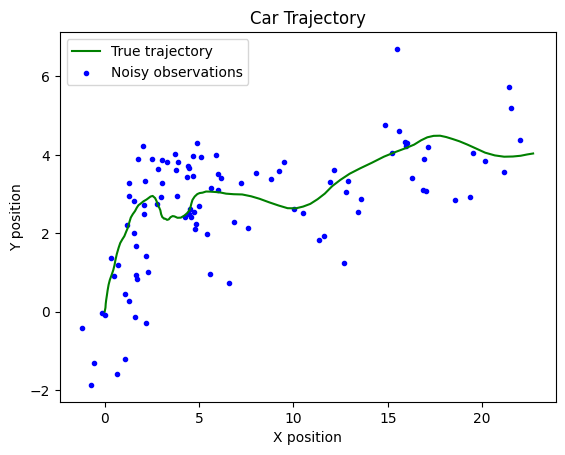

In [11]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

plot_trajectory(true_trajectory, noisy_observations)

In [12]:
m = true_trajectory[0]
n = len(m)
P = np.eye(n)

In [13]:
def UFK(method, m, P, alpha, kappa):

    estimated_trajectory_UKF = [m]
    P_UKF = [P]

    for y in noisy_observations[1:]:
        sigmas = get_sigmas(m, P, alpha=alpha, kappa=kappa, method=method)
        transformed_sigmas = np.array([f(sigma) for sigma in sigmas])

        m_pred = np.sum(Wm[:, None] * transformed_sigmas, axis=0)
        P_pred = np.sum([Wc[i] * np.outer(transformed_sigmas[i] - m_pred, transformed_sigmas[i] - m_pred) for i in range(len(Wc))], axis=0) + Q

        sigmas = get_sigmas(m_pred, P_pred, alpha=alpha, kappa=kappa, method=method)
        sigmas=sigmas.real.astype('float64')
        transformed_sigmas = np.array([h(sigma) for sigma in sigmas])


        mu = np.sum(Wm[:, None] * transformed_sigmas, axis=0)
        S = np.sum([Wc[i] * np.outer(transformed_sigmas[i] - mu, transformed_sigmas[i] - mu) for i in range(len(Wc))], axis=0) + R
        C = np.sum([Wc[i] * np.outer(sigmas[i] - m_pred, transformed_sigmas[i] - mu) for i in range(len(Wc))], axis=0)
        
       
        K = C @ np.linalg.inv(S)
        m = m_pred + K @ (y - mu)
        P = P_pred - K @ S @ K.T
        
        P_UKF.append(P)
        estimated_trajectory_UKF.append(m)
        
    P_UKF = np.array(P_UKF)
    estimated_trajectory_UKF = np.array(estimated_trajectory_UKF)

    return estimated_trajectory_UKF, P_UKF

def URTS(method, m, P, alpha, kappa):

    n, dim_x = estimated_trajectory_UKF.shape

    estimated_trajectory_URTS, P_URTS = estimated_trajectory_UKF.copy(), P_UKF.copy()

    for k in range(n-2,-1,-1):
        m = estimated_trajectory_URTS[k]
        P = P_URTS[k]
        
        sigmas = get_sigmas(m, P, alpha=alpha, kappa=kappa, method=method)
        sigmas=sigmas.real.astype('float64')
        transformed_sigmas = np.array([f(sigma) for sigma in sigmas])
        
        m_pred = np.sum(Wm[:, None] * transformed_sigmas, axis=0)
        P_pred = np.sum([Wc[i] * np.outer(transformed_sigmas[i] - m_pred, transformed_sigmas[i] - m_pred) for i in range(len(Wc))], axis=0) + Q
        D = np.sum([Wc[i] * np.outer(sigmas[i] - m, transformed_sigmas[i] - m_pred) for i in range(len(Wc))], axis=0)
        
        G = D @ np.linalg.inv(P_pred)
        estimated_trajectory_URTS[k] += G @ (estimated_trajectory_URTS[k+1] - m_pred)
        P_URTS[k] += (G @ (P_URTS[k+1] - P_pred)) @ G.T

    return estimated_trajectory_URTS, P_URTS

def visualize_unscented(true_trajectory, noisy_observations, estimated_trajectory_UKF, estimated_trajectory_URTS, method='None'):

    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    for k in range(2):
        ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
        ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
        ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
        ax[k].set_xlabel("x")
        ax[k].set_ylabel("y")
        
    ax[0].plot(estimated_trajectory_UKF[:, 0], estimated_trajectory_UKF[:, 1], label="Estimated trajectory, UFK")
    ax[0].set_title("Unscented Kalman Filter (UKF)")

    ax[1].plot(estimated_trajectory_URTS[:, 0], estimated_trajectory_URTS[:, 1], label="Estimated trajectory, URTS")
    ax[1].set_title("Unscented Rauch-Tung-Striebel Smoother (URTS)")

    # Compute MSE
    UKF_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_UKF[:, :2])**2)
    URTS_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_URTS[:, :2])**2)

    # Show the MSE on the plot in upper right corner
    ax[0].text(1.0, 1.055, "MSE: {:.2f}".format(UKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
    ax[1].text(1.0, 1.055, "MSE: {:.2f}".format(URTS_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

    # # 95% confidence ellipses for the KF
    for i in range(0, len(estimated_trajectory_UKF)):
        conf_ellipse(ax[0], estimated_trajectory_UKF[i, :2], P_UKF[i, :2, :2])
        
    # # 95% confidence ellipses for the EKF
    for i in range(0, len(estimated_trajectory_URTS)):
        conf_ellipse(ax[1], estimated_trajectory_URTS[i, :2], P_URTS[i, :2, :2])

    ax[0].legend()
    ax[1].legend()

    # add title
    fig.suptitle(f"UKF vs. URTS, Sigma-point method: {method}", fontsize=16)
    
    plt.tight_layout()    
    plt.show()

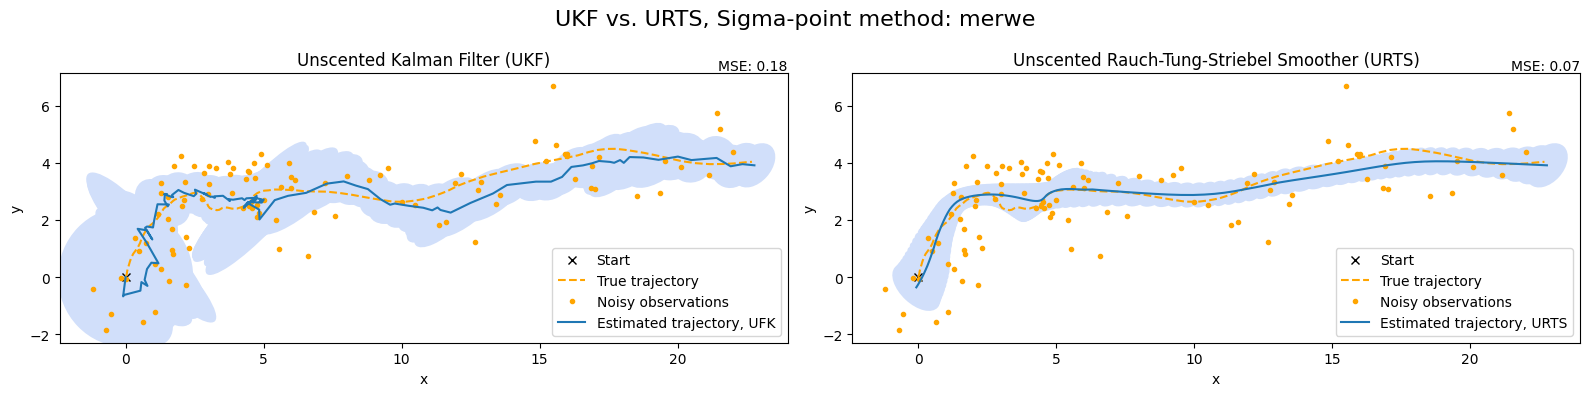

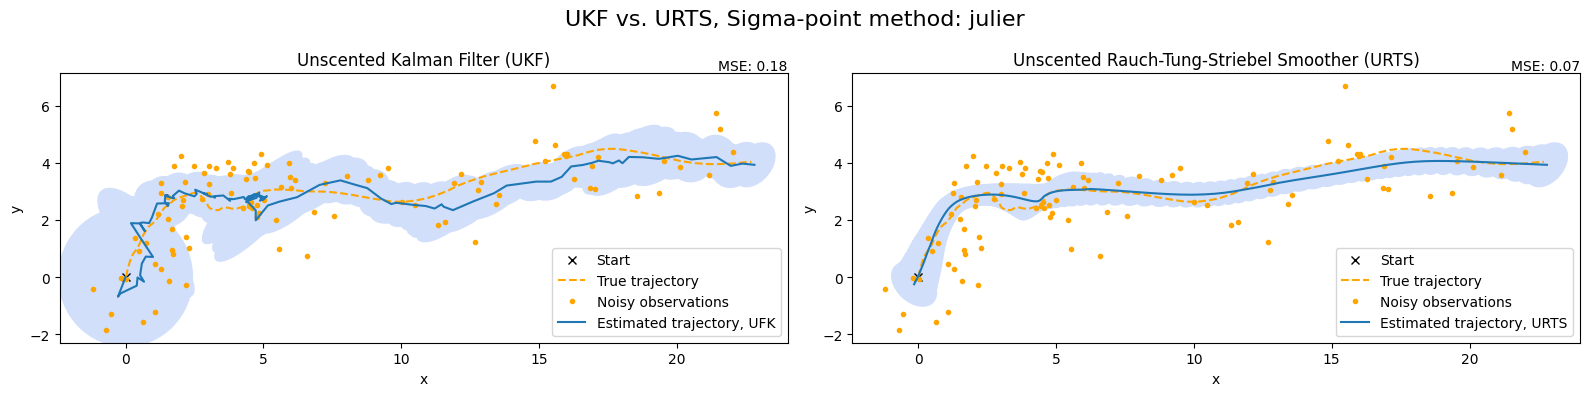

In [14]:

alpha = 0.5
beta = 2
kappa = 0

for method in ['merwe', 'julier']: #, 'simplex']:

    Wm, Wc = get_weights(n=n, alpha=alpha, beta=beta, kappa=kappa, method=method)

    estimated_trajectory_UKF, P_UKF = UFK(method, m, P, alpha, kappa)
    estimated_trajectory_URTS, P_URTS = URTS(method, m, P, alpha, kappa)

    visualize_unscented(true_trajectory, noisy_observations, estimated_trajectory_UKF, estimated_trajectory_URTS, method=method)